## Импорты

In [83]:
import os
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

from data_viz_functions import *

In [84]:
DATA_DIR = 'kaggle/input/'
df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input/sf-scoring.zip
kaggle/input/sample_submission.csv
kaggle/input/train.csv
kaggle/input/test.csv


In [85]:
df_train.dtypes

client_id             int64
app_date             object
education            object
sex                  object
age                   int64
car                  object
car_type             object
decline_app_cnt       int64
good_work             int64
score_bki           float64
bki_request_cnt       int64
region_rating         int64
home_address          int64
work_address          int64
income                int64
sna                   int64
first_time            int64
foreign_passport     object
default               int64
dtype: object

## объединяем трейн и тест для предобработки


In [86]:

df_train['sample'] = 1 # где у нас трейн
df_test['sample'] = 0  # где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

## группируем имена колонок в списки

In [87]:
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

### смотрим числовые

In [88]:
data[num_cols].sample(3)

,age,decline_app_cnt,score_bki,bki_request_cnt,income
21007,55,0,-1.696577,4,27000
61190,32,0,-2.003745,2,60000
68838,54,1,-2.236594,0,100000


In [89]:
describe_nums(data[num_cols])

,unique,n/a count,count,mean,std,min,25%,50%,75%,max
score_bki,102618,0,110148.000000,-1.904535,0.499397,-3.624586,-2.260434,-1.920823,-1.567888,0.199773
income,1207,0,110148.000000,41012.648537,45399.735051,1000.000000,20000.000000,30000.000000,48000.000000,1000000.000000
age,52,0,110148.000000,39.249410,11.518063,21.000000,30.000000,37.000000,48.000000,72.000000
bki_request_cnt,40,0,110148.000000,2.005002,2.266926,0.000000,0.000000,1.000000,3.000000,53.000000
decline_app_cnt,24,0,110148.000000,0.273205,0.799099,0.000000,0.000000,0.000000,0.000000,33.000000


Unique values count: 52 
Q1: 30.0
Q3: 48.0
IQR: 18.0 
Outliers borders: [3.0, 75.0]


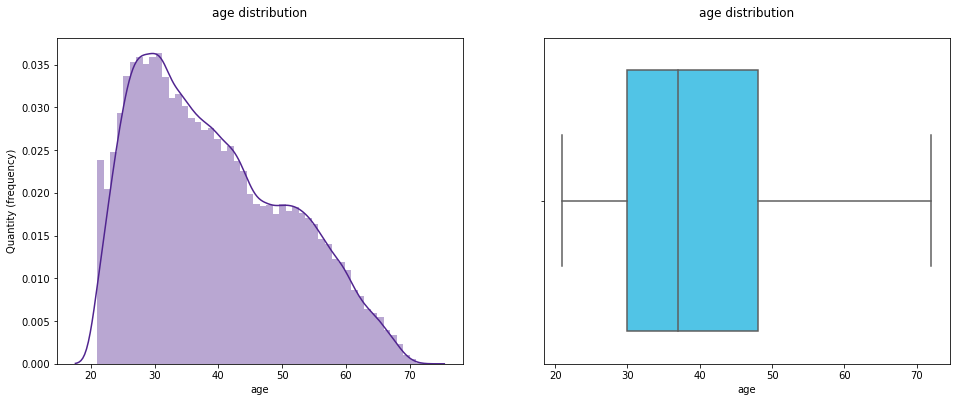

Unique values count: 24 
Q1: 0.0
Q3: 0.0
IQR: 0.0 
Outliers borders: [0.0, 0.0]


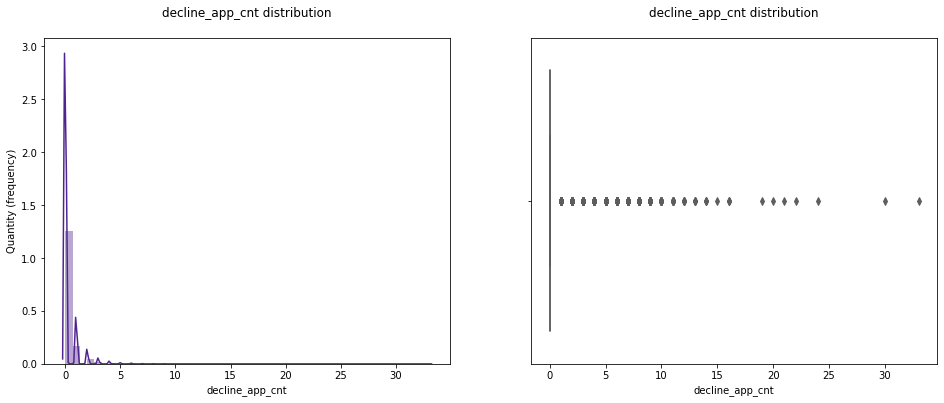

Unique values count: 102618 
Q1: -2.26044074
Q3: -1.5678840649999999
IQR: 0.6925566750000001 
Outliers borders: [-3.2992757525, -0.5290490524999998]


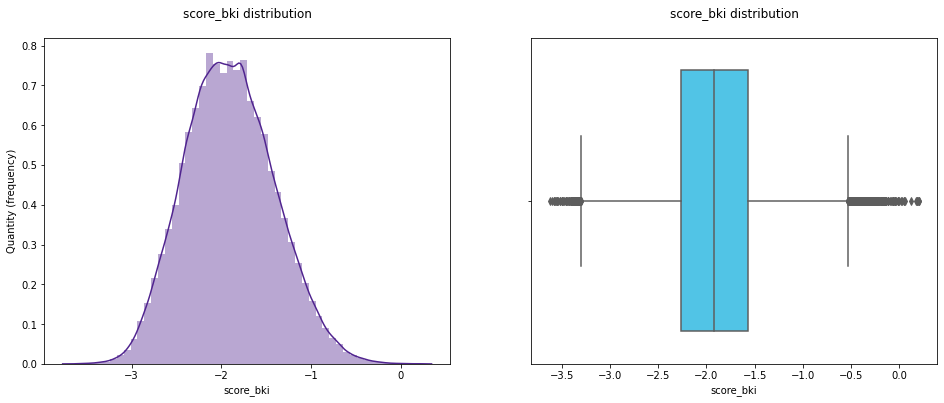

Unique values count: 40 
Q1: 0.0
Q3: 3.0
IQR: 3.0 
Outliers borders: [-4.5, 7.5]


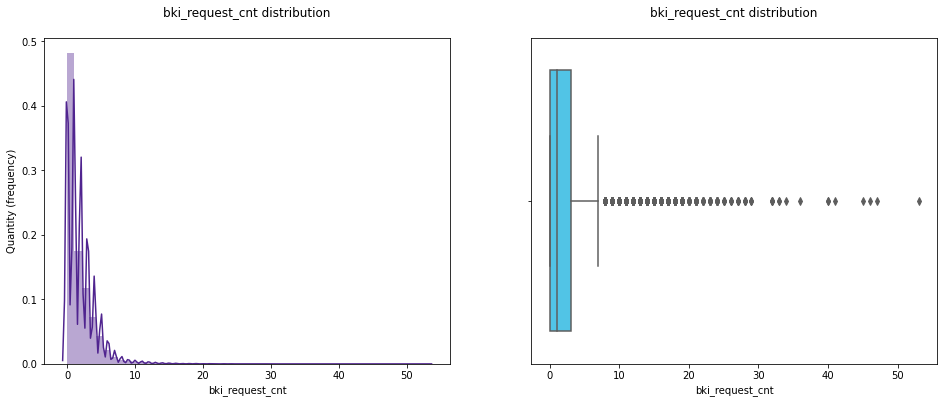

Unique values count: 1207 
Q1: 20000.0
Q3: 48000.0
IQR: 28000.0 
Outliers borders: [-22000.0, 90000.0]


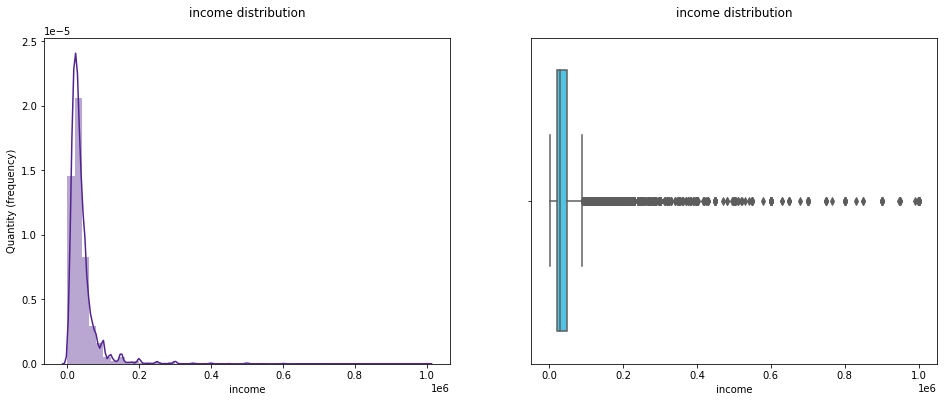

In [107]:
for n in num_cols:
    show_IQR(data[n])

Кроме score_bki все имеют выраженный хвост. Логорифмировать

<AxesSubplot:>

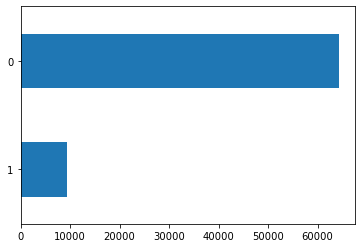

In [106]:
data.loc[data["sample"] == 1]['default'].value_counts(ascending=True).plot(kind='barh')

## корреляция и значимость признаков

In [91]:
data.drop(['client_id','app_date',], axis = 1, inplace=True)

In [92]:
data = pd.get_dummies(data, columns=['education'], dummy_na=True)

In [93]:
le = LabelEncoder()

for column in bin_cols:
    data[column] = le.fit_transform(data[column])
    
columns = ['first_time', 'sna', 'work_address', 'home_address', 'region_rating']

for column in columns:
    data[column] = le.fit_transform(data[column])

In [96]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

X = train_data.drop(['default'], axis=1)
y = train_data['default'].values  # наш таргет

In [97]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
from sklearn.model_selection import train_test_split

# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
# проверяем
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 21), (14760, 21), (59039,), (14760,))

In [99]:
logreg = LogisticRegression(solver='liblinear', max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

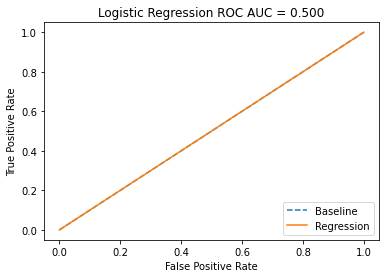

['              precision    recall  f1-score   support',
 '',
 '           0       0.88      1.00      0.93     12933',
 '           1       0.50      0.00      0.00      1827',
 '',
 '    accuracy                           0.88     14760',
 '   macro avg       0.69      0.50      0.47     14760',
 'weighted avg       0.83      0.88      0.82     14760',
 '']


In [100]:
show_classification_details(y_test, y_pred)

## final model

In [101]:
# если качество нас устраивает, обучаем финальную модель на всех обучающи данных
logreg_final = LogisticRegression(solver='liblinear', max_iter=1000)
logreg_final.fit(X, y)

LogisticRegression(max_iter=1000, solver='liblinear')

In [102]:
predict_submission = logreg_final.predict(test_data)

## submission


In [103]:

sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,0
2,75683,0
3,26883,0
4,28862,0
5,99881,0
6,26630,0
7,79934,0
8,16605,0
9,105449,0


In [104]:
sample_submission.describe()

,client_id,default
count,36349.000000,36349.00000
mean,54945.647473,0.00011
std,31706.052195,0.01049
min,4.000000,0.00000
25%,27744.000000,0.00000
50%,54657.000000,0.00000
75%,82322.000000,0.00000
max,110148.000000,1.00000


In [105]:
# !kaggle competitions submit -c sf-scoring -f submission.csv -m "one more try"